# L5d: Min Cost Max Flow as a Linear Programming Problem
In this lab, we will revisit the maximum flow (matching) problem and see how it can be formulated as a linear programming (LP) problem, with the objective of minimizing the cost of the flow. 

> __Learning Objectives:__
> 
> Fill me in.

This is a super useful problem formulation, as it can be used to solve a variety of practical problems, e.g., logistics, supply chain management, or operations and schedule optimization. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and more. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl), check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Constants
Let's define some constants that will be used throughout the notebook. See the comment for a description of each constant, what it represents, its value, units, and more.

In [2]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node (the layout)
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (you)
    10.0 10.0 ; # 1 source node s (x,y) coordinates

    # people nodes (workers)
    11.0 11.0 ; # 2 people node (x,y) coordinates
    11.0 10.0 ; # 3 people node (x,y) coordinates
    11.0 9.0 ; # 4 people node (x,y) coordinates

    # job nodes (tasks)
    12.0 11.0 ; # 5 job node (x,y) coordinates
    12.0 10.0 ; # 6 job node (x,y) coordinates
    12.0 9.0 ; # 7 job node (x,y) coordinates
    12.0 8.0 ; # 8 job node (x,y) coordinates

    # sink nodes (targets, tasks done!)
    13.0 11.0 ; # 9 sink node t (x,y) coordinates
    13.0 10.0 ; # 10 sink node t (x,y) coordinates
    13.0 9.0 ; # 11 sink node t (x,y) coordinates
    13.0 8.0 ; # 12 sink node t (x,y) coordinates
    
    14.0 10.0 ; # 13 end node (x,y) coordinates
];

## Task 1: Build a task allocation graph model
Let's return to the task allocation problem, but with a twist. You're still node `1` (the source node, manager, etc.). We have a small bipartite graph setup: worker nodes connected to task nodes, where we need to allocate workers to tasks. In other words, we need to find a __flow__ through the network, and in particular we'll find the __maximum flow__.

> __Twist:__ We want every worker assigned to tasks such that we use all of our workers' capacity. However, we want the assignments to be made such that the overall cost of the assignments is minimized. In other words, we want to solve a __minimum cost maximum flow__ problem.

The problem graph edges are stored in `data/Workers-Tasks-MCMF-Bipartite.edgelist` with fields: 

> __Records__: Each record in our edgelist file has the comma separated fields: `source,` `target,` `cost,` `lb capacity,` `ub capacity`. The `source` field is the id for the source node, for example `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, the `lb capacity` is the lower bound capacity for the edge, and the `ub capacity` is the upper bound capacity for the edge.

In this activity, we'll ignore the edge weight (set to `1`), and instead will focus on the capacity constraints. Now let's set up our edge parser __callback function__:

In [3]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, and cost (weight) of the edge. 
It returns a tuple containing these values. If the record does not have the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, and cost of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')
    
    # record (five fields)
    # source, target, cost, lb, ub

    fields = split(record, delim) # this assumes a record of the form "source,target,weight"
    if length(fields) < 5 # we have 5 fields
        return nothing
    end

    # get my data from the line -
    source = parse(Int, fields[1]) # source id
    target = parse(Int, fields[2]) # target id
    cost = parse(Float64, fields[3]) # edge weight
    l = parse(Float64, fields[4]) # lower bound capacity
    u = parse(Float64, fields[5]) # upper bound capacity

    # return a tuple -
    return (source, target, cost, l, u)
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [4]:
path_to_edge_file = joinpath(_PATH_TO_DATA, "Workers-Tasks-MCMF-Bipartite.edgelist"); # this points to the graph shown above

Next, construct a dictionary [of `MyConstrainedGraphEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyConstrainedGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyConstrainedGraphEdgeModel}` dictionary.

The keys in the edge dictionary will be the edge ids (which we can assume are unique), and the values will be the corresponding `MyConstrainedGraphEdgeModel` instances. Here, we've used the line index in the edgefile as the edge id.

In [5]:
myedgemodels = MyConstrainedGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

Dict{Int64, MyConstrainedGraphEdgeModel} with 23 entries:
  5  => MyConstrainedGraphEdgeModel(5, 7, 11, 1.0, 0.0, 1.0)
  16 => MyConstrainedGraphEdgeModel(16, 3, 6, 1.0, 0.0, 1.0)
  20 => MyConstrainedGraphEdgeModel(20, 4, 6, 1.0, 0.0, 1.0)
  12 => MyConstrainedGraphEdgeModel(12, 2, 6, 1.0, 0.0, 1.0)
  8  => MyConstrainedGraphEdgeModel(8, 10, 13, 1.0, 0.0, 1.0)
  17 => MyConstrainedGraphEdgeModel(17, 3, 7, 1.0, 0.0, 1.0)
  1  => MyConstrainedGraphEdgeModel(1, 1, 3, 1.0, 0.0, 1.0)
  19 => MyConstrainedGraphEdgeModel(19, 4, 5, 1.0, 0.0, 1.0)
  0  => MyConstrainedGraphEdgeModel(0, 1, 2, 1.0, 0.0, 1.0)
  22 => MyConstrainedGraphEdgeModel(22, 4, 8, 1.0, 0.0, 1.0)
  6  => MyConstrainedGraphEdgeModel(6, 8, 12, 1.0, 0.0, 1.0)
  11 => MyConstrainedGraphEdgeModel(11, 2, 5, 1.0, 0.0, 1.0)
  9  => MyConstrainedGraphEdgeModel(9, 11, 13, 1.0, 0.0, 1.0)
  14 => MyConstrainedGraphEdgeModel(14, 2, 8, 1.0, 0.0, 1.0)
  3  => MyConstrainedGraphEdgeModel(3, 5, 9, 1.0, 0.0, 1.0)
  7  => MyConstrainedGraphEd

Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MyDirectedBipartiteGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyDirectedBipartiteGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MyDirectedBipartiteGraphModel` variable.

In [6]:
myedgemodels[1] |> m-> typeof(m) |> T -> fieldnames(T)

(:id, :source, :target, :weight, :lower, :upper)

In [7]:
directedgraphmodel = let

    # initialize -
    s = 1; # what is the source node
    t = 13; # what is the sink node

    # call the build method to create the graph model
    model = build(MyDirectedBipartiteGraphModel, (
        s = s, # source index
        t = t, # sink index
        edges = myedgemodels
    ));

    
    model # return the model 
end;

In [8]:
directedgraphmodel.sink

13

The code block below shows how we visualized the flow network. 

The nodes in the graph are represented as circles, while the edges are represented as lines connecting these circles. Flow in this case goes from a source node ($s$, or node 1) to a sink node ($t$ or node 13). The numbers above the edges represent the __capacity__ of the edge (upper bound on the flow through the edge).

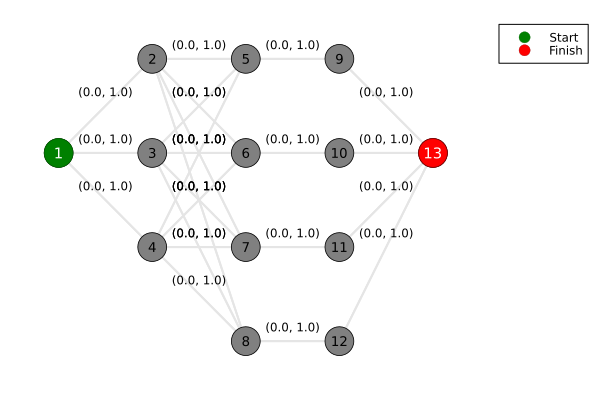

In [9]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        
        # add weight annotation to edges -
        mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        c = round.(base_graphmodel.capacity[(s,t)], digits=2) # changed to capacity from edges
        annotate!(mx, my + 0.15, text(string(c), 8, :black))
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

## Task 2: Formulate the minimum cost maximum flow problem as a linear programming problem
In this task, we translate the data stored in our graph model into the components of our linear programming (LP) problem.  

We have a directed (bipartite) graph with nodes representing sources, sinks, and intermediate nodes representing a matching process. The edges represent the flow of goods or resources between these nodes. Each edge has a capacity (the maximum amount of flow that can pass through it) and a cost per unit of flow.

> __Formulation__: Let the directed graph be represented as $G = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of vertices (nodes) and $\mathcal{E}$ is the set of edges. Each edge $(i, j) \in \mathcal{E}$ has a capacity $c(i,j)$ and a cost (weight) $w(i,j)$ per unit of flow. Let $f_{ij}$ be the flow on edge $(i, j)$, and let $s$ be the source node and $t$ be the sink node. The goal is to maximize the flow from the source to the sink while minimizing the total cost of the flow.

Putting all this together, we can formulate the minimum cost maximum flow problem as the _primal_ linear program:
$$
\begin{align*}
\text{minimize} &\, \sum_{(i,j)\in\mathcal{E}} w(i,j)\;f_{ij} \\
\text{subject to}~\sum_{j:(i,j)\in\mathcal{E}} f_{ij} - \sum_{j:(j,i)\in\mathcal{E}} f_{ji}&=
\begin{cases}
F & \text{if } i = s \\
-F & \text{if } i = t \\
0 & \text{otherwise}
\end{cases}\\
~0 \leq f_{ij}&\leq c(i,j) \quad\forall (i,j) \in \mathcal{E}
\end{align*}
$$
where $F$ is the total flow from the source to the sink. The optimal solution to this problem (if it exists) will give the flow on each edge that minimizes the total cost while satisfying the flow conservation constraints and capacity constraints.

Let's start with the bounds.

In [10]:
directedgraphmodel.edgesinverse

Dict{Int64, Tuple{Int64, Int64}} with 23 entries:
  5  => (2, 6)
  16 => (5, 9)
  20 => (9, 13)
  12 => (4, 5)
  8  => (3, 5)
  17 => (6, 10)
  1  => (1, 2)
  19 => (8, 12)
  22 => (11, 13)
  23 => (12, 13)
  6  => (2, 7)
  11 => (3, 8)
  9  => (3, 6)
  14 => (4, 7)
  3  => (1, 4)
  7  => (2, 8)
  4  => (2, 5)
  13 => (4, 6)
  15 => (4, 8)
  ⋮  => ⋮

In [11]:
directedgraphmodel.capacity

Dict{Tuple{Int64, Int64}, Tuple{Number, Number}} with 23 entries:
  (4, 5)   => (0.0, 1.0)
  (1, 2)   => (0.0, 1.0)
  (8, 12)  => (0.0, 1.0)
  (3, 7)   => (0.0, 1.0)
  (2, 5)   => (0.0, 1.0)
  (6, 10)  => (0.0, 1.0)
  (1, 3)   => (0.0, 1.0)
  (12, 13) => (0.0, 1.0)
  (4, 6)   => (0.0, 1.0)
  (5, 9)   => (0.0, 1.0)
  (1, 4)   => (0.0, 1.0)
  (2, 6)   => (0.0, 1.0)
  (3, 8)   => (0.0, 1.0)
  (11, 13) => (0.0, 1.0)
  (9, 13)  => (0.0, 1.0)
  (4, 7)   => (0.0, 1.0)
  (2, 7)   => (0.0, 1.0)
  (4, 8)   => (0.0, 1.0)
  (2, 8)   => (0.0, 1.0)
  ⋮        => ⋮

In [12]:
bounds = let

    # initialize -
    capacity = directedgraphmodel.capacity; # get the capacity
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    bounds = Array{Float64,2}(undef, number_of_edges, 2); # each row is an edge, col 1 is lb, col 2 is ub

    # TODO: loop over the edges and set the bounds
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;

        # set the bounds
        bounds[edge_index, 1] = capacity[v][1]; # lower bound
        bounds[edge_index, 2] = capacity[v][2]; # upper bound
    end

    bounds # return;
end;

Next, let's formulate the objective function coefficients. The objective function coefficients correspond to the costs associated with each edge in the graph. In our case, we want to minimize the total cost of the flow through the network.

In [13]:
c = let

    # initalize -
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    weight_array = Array{Float64,1}(undef, number_of_edges); # each row is an edge
    weights = directedgraphmodel.edges;

    # main loop -
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;

        # set the weight
        weight_array[edge_index] = weights[v]; # weight
    end
    
    weight_array # return
end;

Now, let's formulate the right-hand side vector, which corresponds to the flow conservation constraints at each node in the graph. The right-hand side vector will have a value of `F` at the source node, `-F` at the sink node, and `0` at all other nodes.

In [14]:
typeof(directedgraphmodel) |> T -> fieldnames(T)

(:nodes, :edges, :children, :edgesinverse, :left, :right, :source, :sink, :capacity)

In [17]:
b = let

    # initialize -
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    b = zeros(number_of_nodes); # each row is a node
    F = 3.0; # this is the total flow we want to push through the network
    s = directedgraphmodel.source; # source node index
    t = directedgraphmodel.sink; # sink node index

    # set the right-hand side values
    b[s] = F; # source node
    b[t] = -F; # sink node

    b; # return
end;